# Student Binary Classification

Determine the classifiers for the student that may lead to a drop out


In [1]:
#update the modules to be used
!pip install matplotlib

In [1]:
#importing the libraries to be used in the 
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px
import numpy as np
import warnings
warnings.filterwarnings('ignore')

To partially automate the process, we shall connect to the google worksheet

In [2]:
#importing libraries to read from googlesheets
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#install gspread pip for connection to google sheet
!pip install --upgrade -q gspread
!pip install gspread-dataframe

In [4]:
#authenticating the account 
import gspread
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
gc = gspread.authorize(GoogleCredentials.get_application_default())



In [177]:
#import the csv format of the dataset
student = gc.open_by_url('https://docs.google.com/spreadsheets/d/1PqGgqRiU4v5tnGqJgXhcfgZFzkqJgIhkimTx3-2oGA4/edit#gid=0')


In [178]:
from gspread_dataframe import get_as_dataframe, set_with_dataframe
ws = student.worksheet('Sheet1')
student_df = get_as_dataframe(ws)

In [179]:
#oberving the data frame
student_df.head()

,Gender,Date of Birth,Age,20-25_years,>28_years,>30_years,Country,LevelStatus,Confirmed Desire to Drop out,Score_1,Score_2,Score_3,Score_4,Score_5,Overal_<60_?,Drop_out,Source,Source part 2,Why drop or behind,Stage,PLD 12 Feb
0,Male,6/16/2000,21.0,1.0,0.0,0.0,Ethiopia,Student accepted to join,Yes,23.72,31.50,34.65,39.53,45.61,Yes,Yes,blank,Google,Balance School,High School,Absent
1,Male,5/27/1992,29.0,0.0,1.0,0.0,Eswatini,Student accepted to join,Yes,0.00,4.55,5.00,0.00,0.00,Yes,Yes,Facebook Organic,l.facebook.com,NaN,NaN,Absent
2,Male,8/29/1997,24.0,1.0,0.0,0.0,Ivory Coast,Student accepted to join,Yes,2.65,7.56,8.31,4.42,5.10,Yes,Yes,Facebook Organic,l.facebook.com,Balance Work,Working,Absent
3,Male,7/15/1998,23.0,1.0,0.0,0.0,Nigeria,Student accepted to join,Yes,10.21,15.69,17.25,16.34,18.85,Yes,Yes,blank,direct,NaN,NaN,Absent
4,Male,5/11/2000,21.0,1.0,0.0,0.0,Rwanda,Student accepted to join,Yes,3.16,8.13,8.95,5.26,6.07,Yes,Yes,Not in System Before Application Import,NaN,NaN,NaN,Absent


In [180]:
#we do not need all the columns for the regression analysis therefore , we shall drop some of them 
# Intial droping of columns was made in the googles sheet
student_df.columns.to_list()

['Gender',
 'Date of Birth',
 'Age',
 '20-25_years',
 '>28_years',
 '>30_years',
 'Country',
 'LevelStatus',
 'Confirmed Desire to Drop out',
 'Score_1',
 'Score_2',
 'Score_3',
 'Score_4',
 'Score_5',
 'Overal_<60_?',
 'Drop_out',
 'Source',
 'Source part 2',
 'Why drop or behind',
 'Stage',
 'PLD 12 Feb']

In [181]:
# looking at the shape of the data frame
shape = student_df.shape
print("{}".format(shape))

(999, 21)


In [182]:
#looking at the columns with Null values
student_df.apply(lambda x: sum(x.isnull()), axis=0)

Gender                          773
Date of Birth                   773
Age                             773
20-25_years                     773
>28_years                       773
>30_years                       773
Country                         773
LevelStatus                     773
Confirmed Desire to Drop out    773
Score_1                         773
Score_2                         773
Score_3                         773
Score_4                         773
Score_5                         773
Overal_<60_?                    773
Drop_out                        773
Source                          773
Source part 2                   823
Why drop or behind              944
Stage                           827
PLD 12 Feb                      773
dtype: int64

There are columns that have > 773 Nan values and we will perform some feature engineering in the columns to get data for > 28 years and > 30 years

In [183]:
student_df.drop(['Date of Birth','Source part 2','Source','Why drop or behind','Stage'], axis = 1, inplace  = True)

In [184]:
#looking at the columns again
student_df.apply(lambda x: sum(x.isnull()), axis = 0)

Gender                          773
Age                             773
20-25_years                     773
>28_years                       773
>30_years                       773
Country                         773
LevelStatus                     773
Confirmed Desire to Drop out    773
Score_1                         773
Score_2                         773
Score_3                         773
Score_4                         773
Score_5                         773
Overal_<60_?                    773
Drop_out                        773
PLD 12 Feb                      773
dtype: int64

In [185]:
# lest us drop the missing values in the data frame
student_df.dropna(inplace=True)


In [186]:
student_df.apply(lambda x: sum(x.isnull()), axis = 0)

Gender                          0
Age                             0
20-25_years                     0
>28_years                       0
>30_years                       0
Country                         0
LevelStatus                     0
Confirmed Desire to Drop out    0
Score_1                         0
Score_2                         0
Score_3                         0
Score_4                         0
Score_5                         0
Overal_<60_?                    0
Drop_out                        0
PLD 12 Feb                      0
dtype: int64

The dataset does not have any missing values, right now, we have dropped all the missing values.

This was done inorder to avoid any disturbance in our model.

In [187]:
student_df.shape

(226, 16)

# Explortory Analysis & Feature Engineering

Comparison between parameters in dropping out

In [188]:
student_df.head(3)

,Gender,Age,20-25_years,>28_years,>30_years,Country,LevelStatus,Confirmed Desire to Drop out,Score_1,Score_2,Score_3,Score_4,Score_5,Overal_<60_?,Drop_out,PLD 12 Feb
0,Male,21.0,1.0,0.0,0.0,Ethiopia,Student accepted to join,Yes,23.72,31.50,34.65,39.53,45.61,Yes,Yes,Absent
1,Male,29.0,0.0,1.0,0.0,Eswatini,Student accepted to join,Yes,0.00,4.55,5.00,0.00,0.00,Yes,Yes,Absent
2,Male,24.0,1.0,0.0,0.0,Ivory Coast,Student accepted to join,Yes,2.65,7.56,8.31,4.42,5.10,Yes,Yes,Absent


In [189]:
#statistical sumamry of the data
student_df.describe()

,Age,20-25_years,>28_years,>30_years,Score_1,Score_2,Score_3,Score_4,Score_5
count,226.000000,226.000000,226.000000,226.000000,226.000000,226.000000,226.000000,226.000000,226.000000
mean,24.575221,0.606195,0.176991,0.061947,51.186858,55.322434,55.845398,53.570752,54.326327
std,3.678902,0.489677,0.382508,0.241594,50.430440,49.901160,49.323075,50.517040,49.814726
min,18.000000,0.000000,0.000000,0.000000,0.000000,4.350000,4.760000,0.000000,0.000000
25%,22.000000,0.000000,0.000000,0.000000,2.000000,6.820000,7.500000,2.665000,2.852500
50%,24.000000,1.000000,0.000000,0.000000,34.765000,40.010000,41.000000,39.030000,42.825000
75%,27.000000,1.000000,0.000000,0.000000,91.395000,95.965000,95.522500,96.127500,97.680000
max,39.000000,1.000000,1.000000,1.000000,168.490000,175.740000,173.430000,171.370000,167.280000


In [190]:
# lookig at the columns and the index, so that we could select columns
for count, i in enumerate(student_df.columns):
  print("{} : {}".format(count, i))

0 : Gender
1 : Age
2 : 20-25_years
3 : >28_years
4 : >30_years
5 : Country
6 : LevelStatus
7 : Confirmed Desire to Drop out
8 : Score_1
9 : Score_2
10 : Score_3
11 : Score_4
12 : Score_5
13 : Overal_<60_?
14 : Drop_out
15 : PLD 12 Feb


In [191]:
scores_df = student_df.iloc[:,[8,9,10,11,12]]

In [193]:
mean_score = scores_df.mean(axis=1)

In [192]:
student_df['mean_score'] = mean_score

In [196]:
student_df.head()

,Gender,Age,20-25_years,>28_years,>30_years,Country,LevelStatus,Confirmed Desire to Drop out,Score_1,Score_2,Score_3,Score_4,Score_5,Overal_<60_?,Drop_out,PLD 12 Feb,mean_score
0,Male,21.0,1.0,0.0,0.0,Ethiopia,Student accepted to join,Yes,23.72,31.50,34.65,39.53,45.61,Yes,Yes,Absent,35.002
1,Male,29.0,0.0,1.0,0.0,Eswatini,Student accepted to join,Yes,0.00,4.55,5.00,0.00,0.00,Yes,Yes,Absent,1.910
2,Male,24.0,1.0,0.0,0.0,Ivory Coast,Student accepted to join,Yes,2.65,7.56,8.31,4.42,5.10,Yes,Yes,Absent,5.608
3,Male,23.0,1.0,0.0,0.0,Nigeria,Student accepted to join,Yes,10.21,15.69,17.25,16.34,18.85,Yes,Yes,Absent,15.668
4,Male,21.0,1.0,0.0,0.0,Rwanda,Student accepted to join,Yes,3.16,8.13,8.95,5.26,6.07,Yes,Yes,Absent,6.314


In [204]:
#we shall rearrange the columns
student_df = student_df.iloc[:,[0, 1,2,3,4,5,6, 8,9,10,11,12,16,13,14]]

In [206]:
#this is the new dataframe that we shall use for our analysis
student_df.head()

,Gender,Age,20-25_years,>28_years,>30_years,Country,LevelStatus,Score_1,Score_2,Score_3,Score_4,Score_5,mean_score,Overal_<60_?,Drop_out
0,Male,21.0,1.0,0.0,0.0,Ethiopia,Student accepted to join,23.72,31.50,34.65,39.53,45.61,35.002,Yes,Yes
1,Male,29.0,0.0,1.0,0.0,Eswatini,Student accepted to join,0.00,4.55,5.00,0.00,0.00,1.910,Yes,Yes
2,Male,24.0,1.0,0.0,0.0,Ivory Coast,Student accepted to join,2.65,7.56,8.31,4.42,5.10,5.608,Yes,Yes
3,Male,23.0,1.0,0.0,0.0,Nigeria,Student accepted to join,10.21,15.69,17.25,16.34,18.85,15.668,Yes,Yes
4,Male,21.0,1.0,0.0,0.0,Rwanda,Student accepted to join,3.16,8.13,8.95,5.26,6.07,6.314,Yes,Yes


In [207]:
#visulizing the age and gender distribution by country
fig = px.histogram(student_df, x='Age', nbins=10, color="Gender", 
                   title = "Student Distribution by age and Country",
                   labels = {#repalces default color mapping by value
                             "Age": "Age distribution",
                             "count":"Number of students"
                       
                   }, hover_name='Country',marginal = "rug")
fig.update_layout(# customize font and legend orientation & position
                  font_family = "Rockwell",
                  legend = dict(
                      orientation="h", y=1, yanchor='bottom', xanchor='center'
                  )
    
)
fig.show()

In [218]:
#visualize the scores and drop outs distribution
fig = px.histogram(student_df, x='mean_score',
                   color='Drop_out', nbins=10, hover_name = 'Country',marginal = 'rug',
                   title="Score Distribution and Drop_Outs",
                   color_discrete_map = { #replace the default color values
                                         'Drop_out = Yes':"cornflowerblue",
                                          'Drop_out = No':"blue"
                       
                   },
                   )
fig.update_layout(# customize fonts and the legends
                  font_family = "Rockwell",
                  legend = dict(
                      orientation="h", y=1, yanchor="bottom", x=0.5, xanchor="center"
                  ))
fig.show()

In [224]:
#visualize the scores and drop outs distribution by country
fig = px.histogram(student_df, x='mean_score',
                   color='Country', nbins=10, hover_name = 'Drop_out',marginal = 'rug',
                   title="Score Distribution and Drop_Outs",
                   
                   )
fig.update_layout(# customize fonts and the legends
                  font_family = "Rockwell",
                  legend = dict(
                      orientation="h", y=0.5, yanchor="bottom", x=1.5, xanchor="center"
                  ))
fig.show()

## Let us replace the variable values to Numerical form & display the Value Counts
This is to avoid disturbance in building the model

In [233]:
student_df.head(3)

,Gender,Age,20-25_years,>28_years,>30_years,Country,LevelStatus,Score_1,Score_2,Score_3,Score_4,Score_5,mean_score,Overal_<60_?,Drop_out
0,1,21.0,1.0,0.0,0.0,Ethiopia,Student accepted to join,23.72,31.50,34.65,39.53,45.61,35.002,1,1
1,1,29.0,0.0,1.0,0.0,Eswatini,Student accepted to join,0.00,4.55,5.00,0.00,0.00,1.910,1,1
2,1,24.0,1.0,0.0,0.0,Ivory Coast,Student accepted to join,2.65,7.56,8.31,4.42,5.10,5.608,1,1


In [226]:
student_df['Drop_out'].replace('Yes', 1, inplace=True)
student_df['Drop_out'].replace('No', 0, inplace=True)

In [229]:
student_df['Drop_out'].value_counts()

1    145
0     81
Name: Drop_out, dtype: int64

In [230]:
student_df.Gender = student_df.Gender.map({'Male': 1, 'Female':0})

In [232]:
student_df['Overal_<60_?'].replace('Yes', 1, inplace=True)
student_df['Overal_<60_?'].replace('No', 0, inplace=True)

In [234]:
student_df['LevelStatus'].value_counts()

Student accepted to join    226
Name: LevelStatus, dtype: int64

## Final DataFrame

In [235]:
student_df.head()

,Gender,Age,20-25_years,>28_years,>30_years,Country,LevelStatus,Score_1,Score_2,Score_3,Score_4,Score_5,mean_score,Overal_<60_?,Drop_out
0,1,21.0,1.0,0.0,0.0,Ethiopia,Student accepted to join,23.72,31.50,34.65,39.53,45.61,35.002,1,1
1,1,29.0,0.0,1.0,0.0,Eswatini,Student accepted to join,0.00,4.55,5.00,0.00,0.00,1.910,1,1
2,1,24.0,1.0,0.0,0.0,Ivory Coast,Student accepted to join,2.65,7.56,8.31,4.42,5.10,5.608,1,1
3,1,23.0,1.0,0.0,0.0,Nigeria,Student accepted to join,10.21,15.69,17.25,16.34,18.85,15.668,1,1
4,1,21.0,1.0,0.0,0.0,Rwanda,Student accepted to join,3.16,8.13,8.95,5.26,6.07,6.314,1,1


# Importing packagees for classification Algortithm

In [237]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [249]:
#split the data into training and test sets
X = student_df.iloc[:,[0,1, 7,8,9,10,11]]
Y = student_df.iloc[:, 14]


0      1
1      1
2      1
3      1
4      1
      ..
221    0
222    0
223    0
224    0
225    0
Name: Drop_out, Length: 226, dtype: int64

In [250]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 0)

# Logistic Regression (LR)

Logistic regression is a supervised learning classification algorithm used to predict the probability of a target variable.

Mathematically, a logistic regression model predicts P(Y=1) as a function of X. It is one of the simplest ML algorithms that can be used for various classification problems such as spam detection, Diabetes prediction, cancer detection etc.


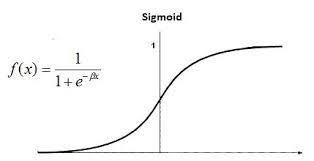

In [251]:
model = LogisticRegression()
model.fit(X_train, y_train)

lr_prediction = model.predict(X_test)
print('Logistic regression accuracy {}'.format(metrics.accuracy_score(lr_prediction, y_test)))

Logistic regression accuracy 0.8970588235294118


In [252]:
print("y_predicted", lr_prediction)
print("y_test", y_test)

y_predicted [1 1 1 0 1 0 1 1 0 0 1 1 1 1 0 1 0 1 1 0 1 0 0 0 1 1 0 1 1 1 1 0 1 0 0 1 1
 0 1 1 0 0 1 1 1 1 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 0 1 1 1 1]
y_test 130    1
83     1
158    1
184    0
76     1
      ..
157    1
4      1
110    1
61     1
52     1
Name: Drop_out, Length: 68, dtype: int64


# Conclusion 
1. The drop out is heavily dependent on the Scores for prediction
2. The Logistic Regression algorithm gives us the maximum Accuracy (89% approx) compared to the other 3 Machine Learning Classification Algorithms.